### Homework 1: Image Classification Problem using CNN

Downloading the necessary libraries

In [ ]:
import os
import tarfile
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive2')

Mounted at /content/drive2


Extract data (if necessary)

In [ ]:
# Dataset path
data_root = "/content/drive2/MyDrive/NYCU/DL/hw1-data/data"

# Extract the dataset if not already done
if not os.path.exists(data_root):
  dataset_path = data_root + "/hw1-data.tar.gz"
  extract_path = data_root + "/hw1-data"
  os.makedirs(extract_path, exist_ok=True)
  with tarfile.open(dataset_path, "r:gz") as tar:
      tar.extractall(path=extract_path)

Normalization and data augmentation

In [ ]:
# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                           hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

Custom test dataset loader

In [ ]:
# Custom test set loader
class TestDataset(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_names = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]

Load data

In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'train'),
                                     transform=transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'val'),
                                   transform=transform_test)
test_dataset = TestDataset(os.path.join(data_root, 'test'),
                           transform=transform_test)

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                         num_workers=2)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False,
                       num_workers=2)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                        num_workers=2)

results_dir = '/content/drive2/MyDrive/NYCU/DL/hw1-results'
os.makedirs(results_dir, exist_ok=True)


Model Setup

In [ ]:
# Loading pretrained ResNet50
net = models.resnet50(pretrained=True)

# Freeze all layers first
for param in net.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc for fine-tuning
for name, param in net.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace the final FC layer with Dropout + FC
num_classes = len(train_dataset.classes)
net.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(net.fc.in_features, num_classes)
)

net = net.to('cuda')

Training setup

In [ ]:
# Compute weights for weighted CE
targets = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(train_dataset.classes)),
    y=targets
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to('cuda')

# Use in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
# Loss function with label smoothing
#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer with only trainable params
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, net.parameters()),
    lr=3e-5, #changed for 1e-4
    weight_decay=1e-4
)

# Cosine annealing learning rate scheduler
EPOCHS = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

Training Loop

In [ ]:
best_val_acc = 0.0
epochs_no_improve = 0
patience = 10

for epoch in range(EPOCHS):
    net.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    losses = []

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loop = tqdm(trainloader, desc="Training", leave=False)

    for inputs, labels in train_loop:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item())

    scheduler.step()

    # Calculate training metrics
    train_loss = train_running_loss / len(trainloader)
    train_acc = 100 * train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
            val_outputs = net(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(net.state_dict(), 'best_model.pth')
        print(f"Saved new best model at epoch {epoch+1} (val acc: {val_acc:.2f}%)")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    print(f'Epoch [{epoch+1}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')
    print(f'              Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')






Epoch 1/50


Saved new best model at epoch 1 (val acc: 43.67%)
Epoch [1] Train Acc: 15.03% | Val Acc: 43.67%
              Train Loss: 4.5355 | Val Loss: 3.2676

Epoch 2/50


Saved new best model at epoch 2 (val acc: 59.33%)
Epoch [2] Train Acc: 41.33% | Val Acc: 59.33%
              Train Loss: 3.5151 | Val Loss: 2.3927

Epoch 3/50


Saved new best model at epoch 3 (val acc: 65.33%)
Epoch [3] Train Acc: 52.18% | Val Acc: 65.33%
              Train Loss: 2.9926 | Val Loss: 2.0227

Epoch 4/50


Saved new best model at epoch 4 (val acc: 70.00%)
Epoch [4] Train Acc: 58.97% | Val Acc: 70.00%
              Train Loss: 2.7023 | Val Loss: 1.8279

Epoch 5/50


Saved new best model at epoch 5 (val acc: 72.33%)
Epoch [5] Train Acc: 63.54% | Val Acc: 72.33%
              Train Loss: 2.5284 | Val Loss: 1.7474

Epoch 6/50


Saved new best model at epoch 6 (val acc: 74.00%)
Epoch [6] Train Acc: 65.79% | Val Acc: 74.00%
              Train Loss: 2.4133 | Val Loss: 1.6683

Epoch 7/50


Saved new best model at epoch 7 (val acc: 78.00%)
Epoch [7] Train Acc: 68.85% | Val Acc: 78.00%
              Train Loss: 2.3070 | Val Loss: 1.5802

Epoch 8/50


Saved new best model at epoch 8 (val acc: 78.67%)
Epoch [8] Train Acc: 70.54% | Val Acc: 78.67%
              Train Loss: 2.2447 | Val Loss: 1.5162

Epoch 9/50


No improvement for 1 epoch(s)
Epoch [9] Train Acc: 72.49% | Val Acc: 77.67%
              Train Loss: 2.1817 | Val Loss: 1.4980

Epoch 10/50


Saved new best model at epoch 10 (val acc: 80.00%)
Epoch [10] Train Acc: 73.28% | Val Acc: 80.00%
              Train Loss: 2.1310 | Val Loss: 1.4628

Epoch 11/50


No improvement for 1 epoch(s)
Epoch [11] Train Acc: 74.58% | Val Acc: 79.33%
              Train Loss: 2.0888 | Val Loss: 1.4525

Epoch 12/50


Saved new best model at epoch 12 (val acc: 80.67%)
Epoch [12] Train Acc: 75.33% | Val Acc: 80.67%
              Train Loss: 2.0528 | Val Loss: 1.4462

Epoch 13/50


Saved new best model at epoch 13 (val acc: 81.00%)
Epoch [13] Train Acc: 75.96% | Val Acc: 81.00%
              Train Loss: 2.0294 | Val Loss: 1.4171

Epoch 14/50


Saved new best model at epoch 14 (val acc: 82.33%)
Epoch [14] Train Acc: 76.92% | Val Acc: 82.33%
              Train Loss: 1.9945 | Val Loss: 1.4124

Epoch 15/50


No improvement for 1 epoch(s)
Epoch [15] Train Acc: 78.33% | Val Acc: 81.00%
              Train Loss: 1.9709 | Val Loss: 1.4207

Epoch 16/50


No improvement for 2 epoch(s)
Epoch [16] Train Acc: 78.31% | Val Acc: 82.33%
              Train Loss: 1.9682 | Val Loss: 1.3920

Epoch 17/50


No improvement for 3 epoch(s)
Epoch [17] Train Acc: 78.72% | Val Acc: 82.33%
              Train Loss: 1.9351 | Val Loss: 1.3952

Epoch 18/50


Saved new best model at epoch 18 (val acc: 82.67%)
Epoch [18] Train Acc: 79.84% | Val Acc: 82.67%
              Train Loss: 1.9083 | Val Loss: 1.4071

Epoch 19/50


No improvement for 1 epoch(s)
Epoch [19] Train Acc: 80.21% | Val Acc: 82.33%
              Train Loss: 1.8984 | Val Loss: 1.4060

Epoch 20/50


No improvement for 2 epoch(s)
Epoch [20] Train Acc: 80.53% | Val Acc: 81.33%
              Train Loss: 1.8791 | Val Loss: 1.4087

Epoch 21/50


Saved new best model at epoch 21 (val acc: 83.33%)
Epoch [21] Train Acc: 81.22% | Val Acc: 83.33%
              Train Loss: 1.8690 | Val Loss: 1.3839

Epoch 22/50


No improvement for 1 epoch(s)
Epoch [22] Train Acc: 80.92% | Val Acc: 82.00%
              Train Loss: 1.8621 | Val Loss: 1.3871

Epoch 23/50


Saved new best model at epoch 23 (val acc: 84.00%)
Epoch [23] Train Acc: 81.96% | Val Acc: 84.00%
              Train Loss: 1.8298 | Val Loss: 1.3811

Epoch 24/50


No improvement for 1 epoch(s)
Epoch [24] Train Acc: 81.93% | Val Acc: 84.00%
              Train Loss: 1.8259 | Val Loss: 1.3721

Epoch 25/50


No improvement for 2 epoch(s)
Epoch [25] Train Acc: 82.46% | Val Acc: 82.00%
              Train Loss: 1.8255 | Val Loss: 1.3867

Epoch 26/50


No improvement for 3 epoch(s)
Epoch [26] Train Acc: 82.57% | Val Acc: 82.00%
              Train Loss: 1.8117 | Val Loss: 1.3875

Epoch 27/50


No improvement for 4 epoch(s)
Epoch [27] Train Acc: 82.97% | Val Acc: 83.00%
              Train Loss: 1.8122 | Val Loss: 1.3941

Epoch 28/50


No improvement for 5 epoch(s)
Epoch [28] Train Acc: 83.16% | Val Acc: 83.00%
              Train Loss: 1.7963 | Val Loss: 1.3847

Epoch 29/50


No improvement for 6 epoch(s)
Epoch [29] Train Acc: 82.95% | Val Acc: 83.33%
              Train Loss: 1.7927 | Val Loss: 1.3797

Epoch 30/50


No improvement for 7 epoch(s)
Epoch [30] Train Acc: 83.26% | Val Acc: 83.00%
              Train Loss: 1.7864 | Val Loss: 1.3800

Epoch 31/50


Saved new best model at epoch 31 (val acc: 85.00%)
Epoch [31] Train Acc: 83.67% | Val Acc: 85.00%
              Train Loss: 1.7654 | Val Loss: 1.3780

Epoch 32/50


No improvement for 1 epoch(s)
Epoch [32] Train Acc: 84.11% | Val Acc: 84.67%
              Train Loss: 1.7702 | Val Loss: 1.3911

Epoch 33/50


No improvement for 2 epoch(s)
Epoch [33] Train Acc: 84.50% | Val Acc: 82.67%
              Train Loss: 1.7562 | Val Loss: 1.3753

Epoch 34/50


No improvement for 3 epoch(s)
Epoch [34] Train Acc: 84.42% | Val Acc: 84.33%
              Train Loss: 1.7579 | Val Loss: 1.3941

Epoch 35/50


No improvement for 4 epoch(s)
Epoch [35] Train Acc: 84.18% | Val Acc: 83.00%
              Train Loss: 1.7699 | Val Loss: 1.3935

Epoch 36/50


No improvement for 5 epoch(s)
Epoch [36] Train Acc: 84.40% | Val Acc: 82.33%
              Train Loss: 1.7577 | Val Loss: 1.4025

Epoch 37/50


No improvement for 6 epoch(s)
Epoch [37] Train Acc: 84.71% | Val Acc: 84.00%
              Train Loss: 1.7531 | Val Loss: 1.3913

Epoch 38/50


No improvement for 7 epoch(s)
Epoch [38] Train Acc: 84.55% | Val Acc: 84.33%
              Train Loss: 1.7491 | Val Loss: 1.3976

Epoch 39/50


No improvement for 8 epoch(s)
Epoch [39] Train Acc: 84.73% | Val Acc: 84.33%
              Train Loss: 1.7474 | Val Loss: 1.3881

Epoch 40/50


No improvement for 9 epoch(s)
Epoch [40] Train Acc: 84.66% | Val Acc: 84.33%
              Train Loss: 1.7405 | Val Loss: 1.3871

Epoch 41/50


No improvement for 10 epoch(s)
Early stopping at epoch 41


In [ ]:
torch.save(net.state_dict(), f'{results_dir}/resnet50_final.pth')
print("Model checkpoint saved as resnet50_final.pth")

Model checkpoint saved as resnet50_final.pth


Create prediction.csv

In [ ]:
# Rebuild your model
net = models.resnet50(pretrained=False)
num_classes = len(train_dataset.classes)  # 100
net.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(net.fc.in_features, num_classes)
)
net.load_state_dict(torch.load(f'{results_dir}/resnet50_final.pth'))  # Load saved best model
net = net.to('cuda')
net.eval()

# Invert the class_to_idx dictionary to map predicted index back to correct string label
idx_to_classname = {v: k for k, v in train_dataset.class_to_idx.items()}

# Run inference on test set and map predictions to string labels
corrected_predictions = []
with torch.no_grad():
    for images, image_names in tqdm(testloader, desc="Generating corrected prediction.csv"):
        images = images.to('cuda')
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

        for fname, pred in zip(image_names, preds):
            label_str = idx_to_classname[pred]  # Map numeric index -> correct label string
            corrected_predictions.append((fname, label_str))

# Save the corrected predictions
corrected_pred_df = pd.DataFrame(corrected_predictions, columns=['image_name', 'pred_label'])
corrected_pred_df.to_csv(f'{results_dir}/prediction_fixed.csv', index=False)
print("prediction_fixed.csv saved with correct label mapping!")


Generating corrected prediction.csv: 100%|██████████| 19/19 [14:38<00:00, 46.23s/it]


✅ prediction_fixed.csv saved with correct label mapping!


Training curves

Saved loss_curve.png and accuracy_curve.png


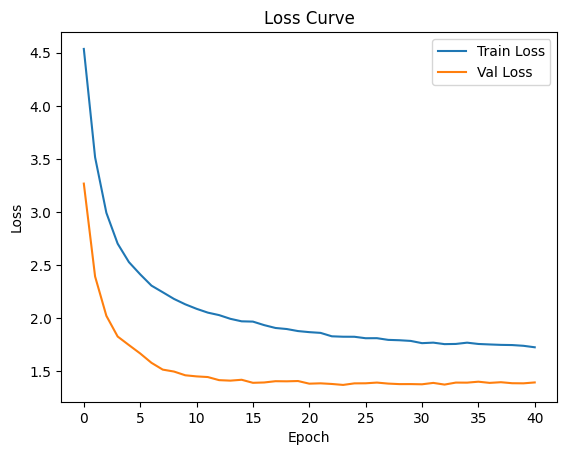

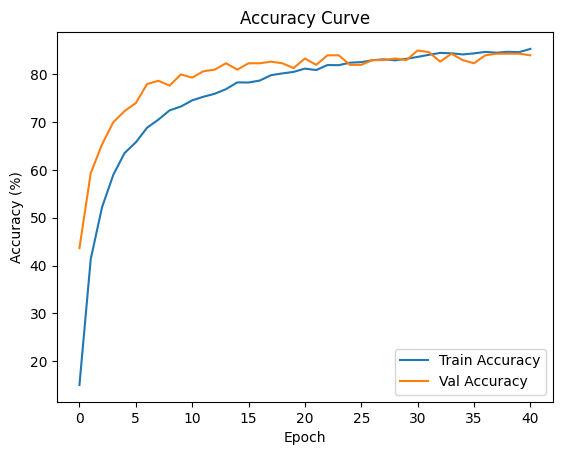

In [ ]:
# Training & validation loss
plt.figure()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(f'{results_dir}/loss_curve.png')

# Training & validation accuracy
plt.figure()
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig(f'{results_dir}/accuracy_curve.png')

print("Saved loss_curve.png and accuracy_curve.png")


Confusion matrix

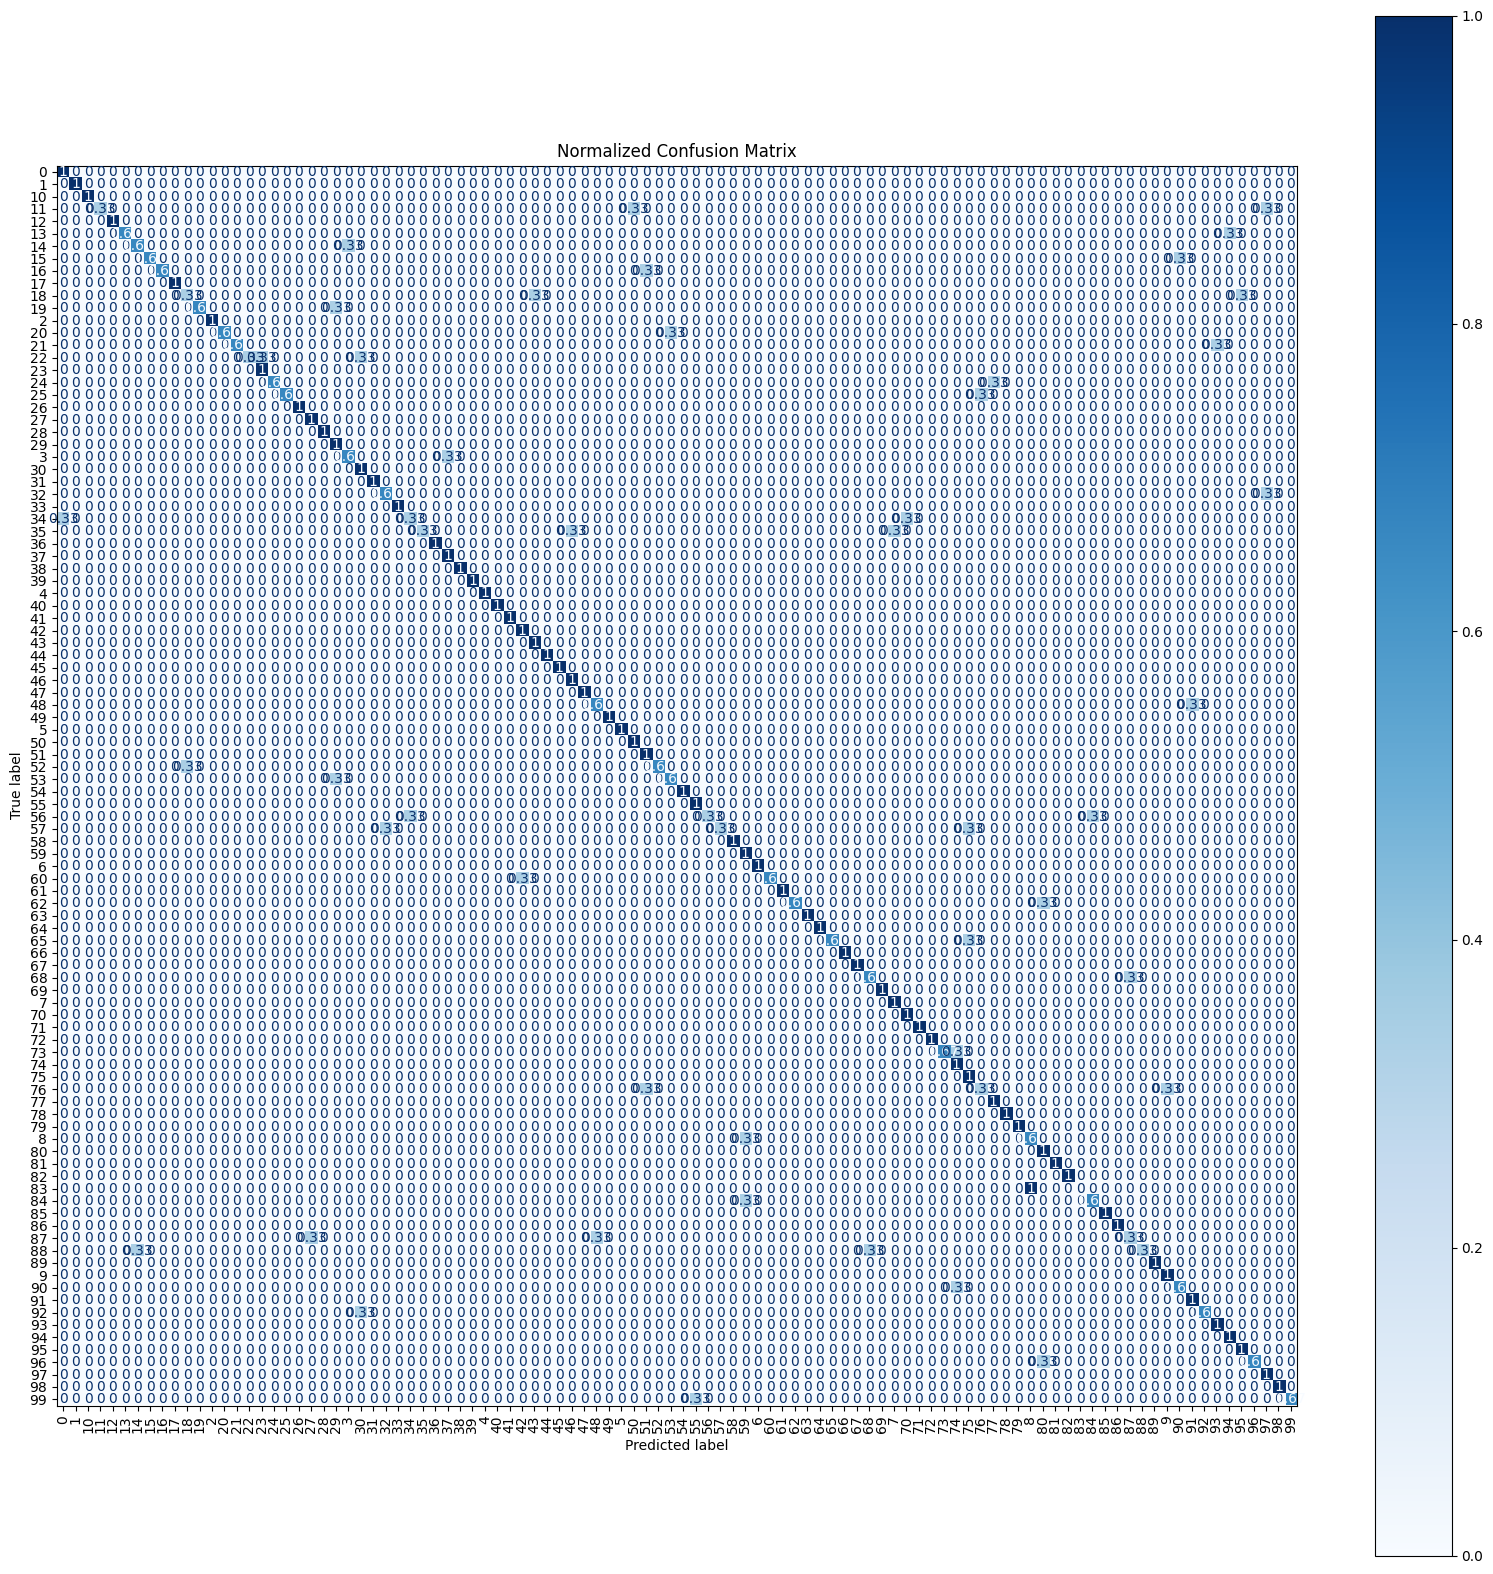

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valloader:
        inputs = inputs.to('cuda')
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.savefig("confusion_matrix_normalized.png")
